In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ESTCampAI/Deeplearning/LangChain

/content/drive/MyDrive/ESTCampAI/Deeplearning/LangChain


- 의존성 라이브러리 설치

In [3]:
!pip install -qU langchain langchain-openai langchain-community duckduckgo-search wikipedia ddgs
!pip install -qU tavily-python langgraph langchain-tavily

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

- API 키 등록

In [ ]:

api_key = ""

# 환경변수 등록
import os

# 추가 - 지정하고 대입
os.environ["OPENAI_API_KEY"] = api_key

## 에이전트(Agent)란?

- LLM이 **스스로 판단하여 적절한 도구(Tool)를 선택·실행**하며 문제를 해결하도록 설계된 컴포넌트
> 즉, 단순 모델 호출이 아닌 **“추론(Reasoning) + 행동(Action)”** 기반의 지능형 실행 엔진

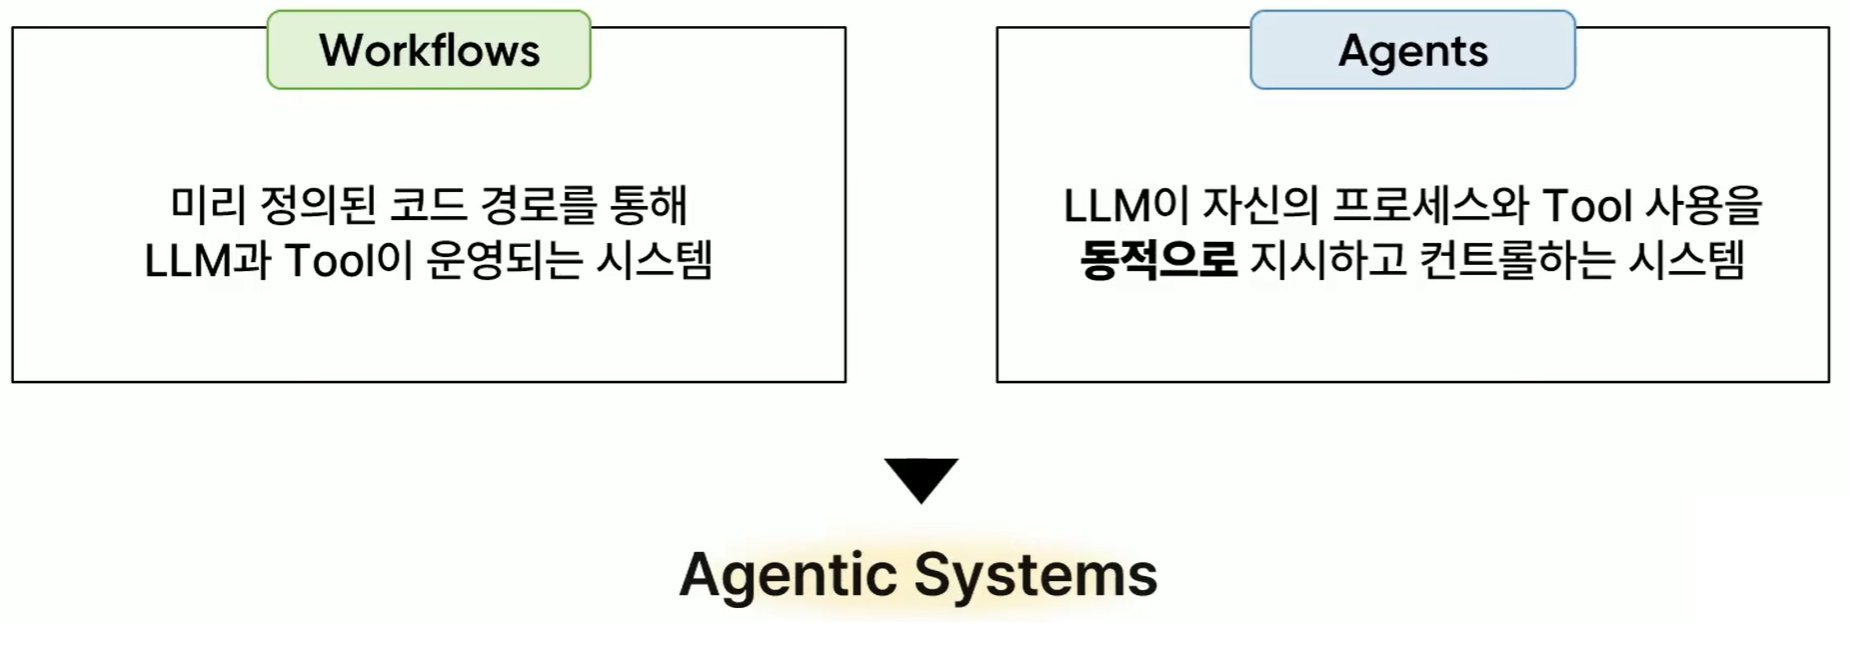

## Router?
- LLM이 다음에 어떤 단계를 취할 지 결정하는 역할
- 여러 Tool 중 어떤 Tool을 선택할 지 등 `선택`을 나타내는 구조

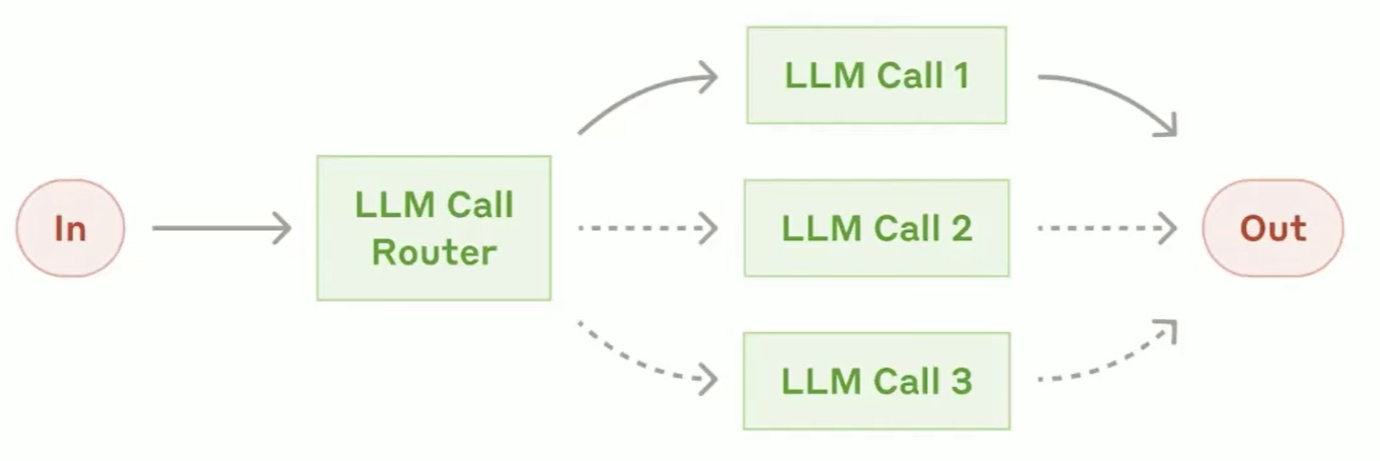

## 🔹 Router는 Agent의 가장 기초 형태

| 유형               | LLM 역할     | 위험도 | 개발 난이도 |
| ---------------- | ---------- | --- | ------ |
| Router           | 분기 결정만     | 낮음  | 매우 쉬움  |
| Tool Agent       | 도구 호출 판단   | 중   | 보통     |
| Fully Autonomous | 계획 + 실행 반복 | 높음  | 복잡     |

* <b>Router</b> → AI가 분기만 결정하므로 가장 안전
* <b>Fully Autonomous</b> → 모든 걸 스스로 판단하고 반복 실행함으로 강력하지만 통제 필요

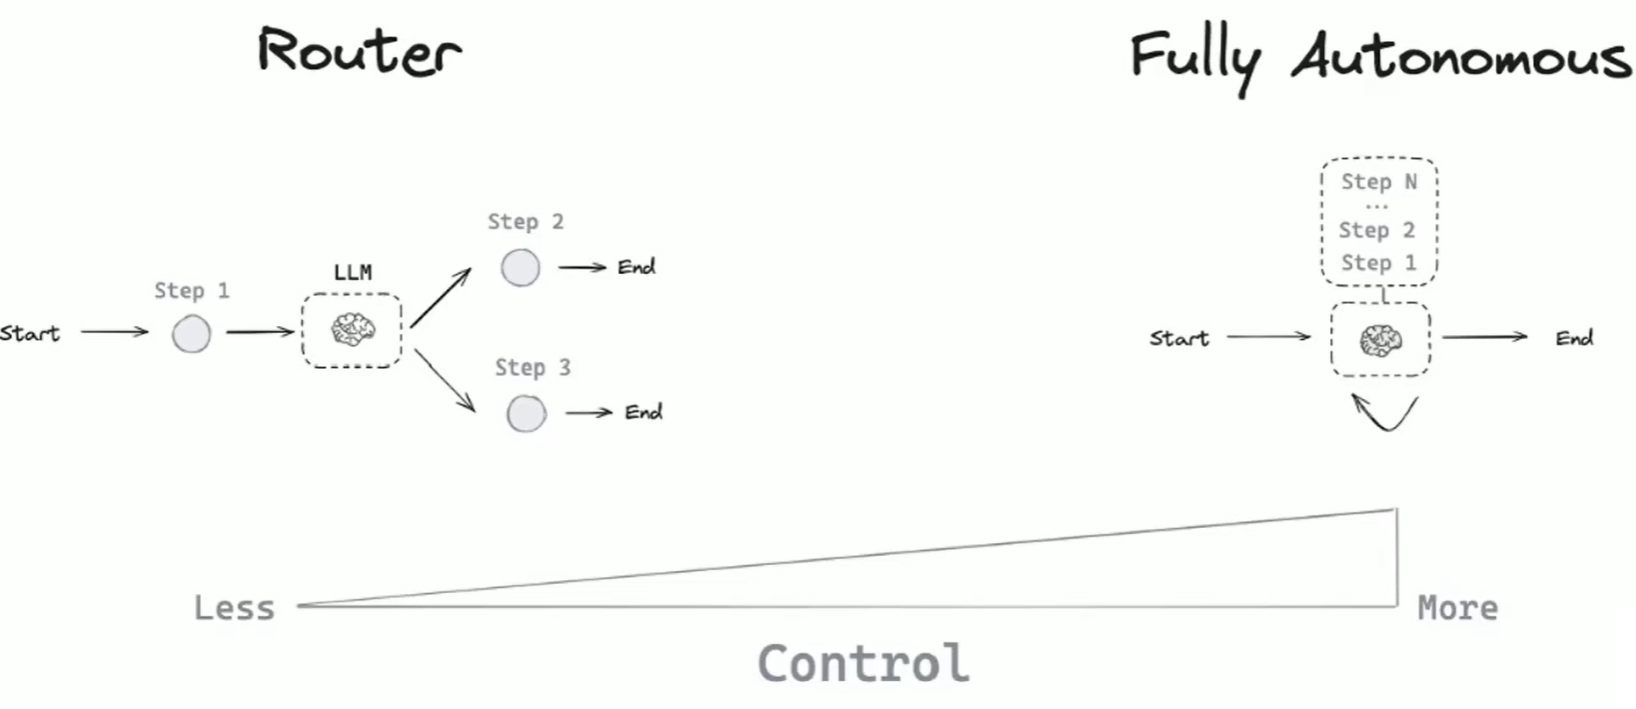

### 🧠 Router Agent

* <b>Step 1 실행하고 → LLM에게 전달</b>
* LLM은 <b>“Step2로 갈지 Step3으로 갈지”</b>만 결정
* 이후 선택된 Step으로 바로 종료

`Start → Step1 → LLM(router) → Step2 or Step3 → End`

→ “LLM은 선택자(Selector)”<br>
→ 사람이 설계한 흐름 안에서만 움직인다”<br>
→ <b>Control이 적음(Less)</b>”<br>

### 🤖 Fully Autonomous Agent

* LLM이 전체 과정을 <b>스스로 계획</b>
* Step 1, Step 2, Step N 을 자기 판단에 따라 수행
* <b>도구 호출 / 다음 행동 / 종료 여부까지 모두 결정</b>

`Start → LLM(Planning + Acting 반복 Loop) → End`

→ “LLM은 실행자 + 계획자 + 조정자(All-in-one)”<br>
→ <b>Control이 많음(More)</b>”<br>
→ GPT Agent, Auto-GPT, Devin 방식이 여기에 속함”<br>

# 간단한 수동 Agent 구현
- 계산기 도구를 하나 정의하여, LLM이 도구를 사용할지 말지 스스로 결정하게 해보기

In [5]:
from langchain.chat_models import init_chat_model
from langchain_core.output_parsers import StrOutputParser
from langchain_core.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

from langchain.tools import tool # 랭체인이 제공하는 데코레이터
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
# ToolMessage : 정의 된 도구가 반환한 결과를 표현하는 메세지

In [6]:
# 모델 초기화
llm = init_chat_model(
    model = "openai:gpt-4.1",
    temperature = 0,
    max_tokens = 500,
    streaming = True,
    callbacks = [StreamingStdOutCallbackHandler()]
)

### @tool
- LangChain에서 "파이썬 함수를 에이전트가 사용할 수 있는 Tool로 변환"하는 데코레이터
- 그냥 함수 ➝ LLM이 쓸 수 있는 Tool 로 변신시키는 기능

> 파이썬 함수를 `name`(도구 이름), `description`(도구 설명), `parameters`(입력 스키마), `return type`(출력) 이 모두를 포함한 LangChain Tool 객체로 자동 변환

<br>

- @tool을 붙이면 해당 기능이 자동으로 생김
1. LLM이 tool_call을 만들 때 사용할 JSON Schema 자동 생성
    > → LLM이 "calculator(expression='2+3')" 형태의 도구 호출을 정확히 생성할 수 있음

2. 도구 이름 자동 등록 (기본은 함수명)
    > → name="calculator"

3. 함수의 docstring을 읽어 description으로 사용
    > → LLM이 "이 도구가 무엇을 하는지" 이해하는 데 도움

4. 함수의 타입힌트(파라미터 타입)를 읽어 입력 스키마 자동 생성
    > → {"expression": string} 같은 Schema가 자동으로 만들어짐

5. Python 함수 → LangChain Tool 객체 변환
    > → bind_tools([calculator]) 로 LLM에게 연결할 수 있게 됨

In [7]:
# 사용할 함수 테스트
eval("(2 + 3) * 5") # 파이썬 내장함수, 문자열 식을 파이썬 표현식으로 해석해서 수치로 계산해주는 도구

25

In [8]:
# 간단한 Tool(도구) 정의 - 실습 상 간단하게 정의 → 실제 서비스 상에서는 입력검증 필요(또는 API 연결)

@tool
def calculator(expression : str) -> str :
  """
  간단한 사칙연산 수식을 계산해주는 도구
  """
  try :
    result = eval(expression)
    return str(result)        # LLM이 읽을 수 있도록 str로 형변환
  except Exception as e :     # 계산에 실패하면, 에러 메세지를 문자열로 반환
    return f"계산 오류 {e}"

In [9]:
# 도구를 쓸 수 있는 LLM 생성
llm_with_tools = llm.bind_tools([calculator])

# 랭체인 1.x ver 에서는 도구 목록을 바인딩 할 수 있음
# 바인딩 : 엮어두는 것
# 바인딩해두면, 모델이 응답을 생성할 때 "일반적인 답변 vs tool_call을 해서 답변을 만들지"를 스스로 결정

```python
RunnableBinding(                # RunnableBinding : '도구를 사용할 수 있는 LLM' 이라는 뜻
    bound=ChatOpenAI(...),      # ← 내부적으로 GPT-4.1 모델을 사용하고 있다는 뜻
    profile = {... 'tool_calling': True ...}, # 해당 모델은 "도구를 호출할 수 있는 능력(tool_calling=True)"이 활성화된 상태
                                # LLM이 스스로 “calculator를 쓰는 게 좋겠다”라고 판단할 수 있음
    kwargs={                    # 모델에 바인딩된 도구 리스트 정보
        'tools': [
            {
                'type': 'function',
                'function': {
                    'name': 'calculator',                 # ← 우리가 만든 도구 이름, 여기서는 calculator라는 하나의 Tool을 갖고 있음
                    'description': "간단한 사칙연산 수식을 계산...",
                    'parameters': {                      # ← 도구가 어떤 입력을 받는지 명시
                        'properties': {
                            'expression': {'type': 'string'}  # expression이라는 문자열 인자를 받는다
                        },
                        'required': ['expression'],
                        'type': 'object'
                    }
                }
            }
        ]
    }
)

# llm_with_tools 는 “GPT-4.1 + calculator 도구 사용 가능" 상태의 LLM
#   → 이제 invoke() 했을 때, 모델이 필요하면 자동으로 tool_call을 생성할 수 있음
```

- 수동으로 한 번 도구 호출해보기 (수동 에이전트 루프 전 단계)
    - 아직 "에이전트 전체 루프"는 구현하지 않고, "질문 1번 → 모델이 필요하면 도구 1번 호출" 정도만 구현

In [10]:
# 사용자 질의 정의 - 사용자가 자연어로 질의를 던지는 상황
human_msg = "2와 3을 더하고, 5를 곱한 값을 계산해줘. 계산 과정은 자세히 말하지 말고, 결과만 말해"

In [11]:
# 도구를 사용할 수 있는 LLM에 전달
ai_msg = llm_with_tools.invoke(human_msg)
ai_msg

AIMessage(content='', additional_kwargs={}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_09249d7c7b', 'service_tier': 'default', 'model_provider': 'openai'}, id='lc_run--019b0605-eb2b-7353-bc04-cde5c1a588e6', tool_calls=[{'name': 'calculator', 'args': {'expression': '(2+3)*5'}, 'id': 'call_BDdYbxopToc8uKX6rbHeoGe4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 19, 'total_tokens': 103, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [12]:
# 도구 호출 여부 확인
ai_msg.tool_calls

[{'name': 'calculator',
  'args': {'expression': '(2+3)*5'},
  'id': 'call_BDdYbxopToc8uKX6rbHeoGe4',
  'type': 'tool_call'}]

```python

[
  {
    'name': 'calculator',                 # ← @tool 데코레이터로 만든 calculator 도구를 선택했다는 의미
    'args': {'expression': '(2 + 3) * 5'},# ← 도구에 전달할 실제 입력값
    'id': 'call_PjDyAU3QqMlYflP5HLOLoOdK',# ← 호출을 구분하기 위한 고유 ID
    'type': 'tool_call'                   # ← 이 이벤트가 "도구 호출 요청"임을 명시하는 필드
  }
]

```

- 도구 실행 → 결과를 다시 LLM에 넣어보기 (수동 에이전트 루프 1회)
- 여기서 “에이전트가 도구를 쓰는 과정”을 우리가 직접 코드로 한 번 구현해보기

In [13]:
# 지금까지의 대화 기록을 리스트에 할당
history = [human_msg, ai_msg]
# human_msg : 사용자 질의
# ai_msg : 도구를 써야해 라고 판단한 tool_call (도구 호출 요청)

##### 만약 tool_calls가 있다면, 직접 도구를 실행

In [14]:
# ToolMessage를 담아둘 리스트 초기화
tool_results = []

In [15]:
# 호출할 도구와 인자 출력,
for call in ai_msg.tool_calls :
  tool_name = call["name"]
  tool_args = call["args"]
  print(f"호출할 도구명 : {tool_name}")
  print(f"전달될 인자값 : {tool_args}")

  if tool_name == "calculator" :
    result = calculator.invoke(tool_args) # Tool 객체를 실행하는 함수(랭체인이 알아서 매핑해서 전달해줌)
    print(result)

    # 도구 실행 결과를 LLM에게 전달할 수 있는 메세지 형태로 변환해서, 리스트에 추가
    tool_results.append(ToolMessage(content = result, tool_call_id = call["id"]))

호출할 도구명 : calculator
전달될 인자값 : {'expression': '(2+3)*5'}
25


In [16]:
tool_results

[ToolMessage(content='25', tool_call_id='call_BDdYbxopToc8uKX6rbHeoGe4')]

In [17]:
# 도구 실행 결과를 history에 추가
history.extend(tool_results)

In [18]:
history
# 사용자 질의 → 추론 → 도구 요청 → 도구 실행 결과 담겨져있는 메세지 리스트

['2와 3을 더하고, 5를 곱한 값을 계산해줘. 계산 과정은 자세히 말하지 말고, 결과만 말해',
 AIMessage(content='', additional_kwargs={}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_09249d7c7b', 'service_tier': 'default', 'model_provider': 'openai'}, id='lc_run--019b0605-eb2b-7353-bc04-cde5c1a588e6', tool_calls=[{'name': 'calculator', 'args': {'expression': '(2+3)*5'}, 'id': 'call_BDdYbxopToc8uKX6rbHeoGe4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 19, 'total_tokens': 103, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 ToolMessage(content='25', tool_call_id='call_BDdYbxopToc8uKX6rbHeoGe4')]

In [19]:
# 최종 답변 생성해보기
final_ai_msg = llm_with_tools.invoke(history)

결과는 25입니다.

##### ✅ 여기까지(한 번의 흐름)가 Action(도구 실행)과 Observation(도구 결과 사용)
- ReAct 루프 : Reason → Action → Observation → Final Answer

## 🔍 ReAct(Reasoning + Acting)
- LangChain의 대표적인 에이전트 전략으로, LLM이 **추론(Reasoning)** 과 **행동(Action)** 을 번갈아가며 수행하도록 만드는 방식
- * LLM이 스스로 생각을 글로 작성해(Thought), 다음 행동(Action)을 선택하며, 필요한 경우 Observation(관찰 결과)를 받아 다시 추론을 이어감 <br>
- → 즉, **“생각하며 문제를 해결하는 LLM”** 을 구현하는 패턴





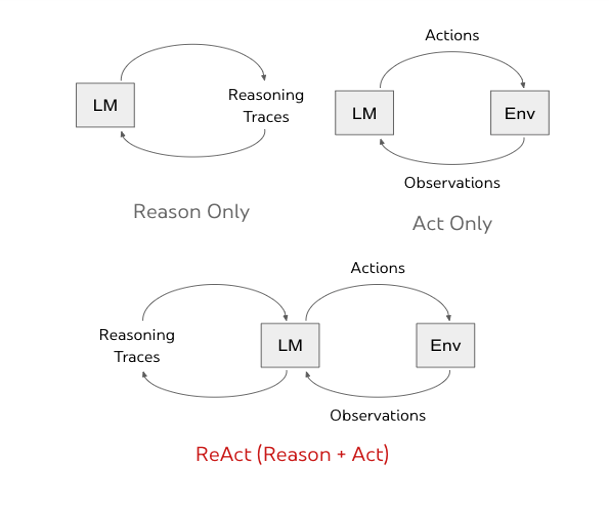

##### 🔍 ReAct 구조 이해하기

> 1) Reason Only 시스템
> - LM(언어모델) → 스스로 “생각(Reasoning Traces)”만 반복
> - 외부 환경(Environment)과 상호작용 없음
> - 예: 단순 질문 응답, 텍스트 내 추론
> - 한계: 필요한 정보가 외부에 있어도 가져올 수 없음

> 2) Act Only 시스템
> - LM → 바로 행동(Action)을 실행
> - 환경(Environment)에서 Observation(관찰 결과)만 받음
> - Reasoning(생각 과정)이 없음
> - 예: 모델이 어떤 기준 없이 바로 Tool 실행
> - 한계: 잘못된 행동을 연달아 수행할 위험 → 실수 교정 불가

> 3) ⭐ ReAct = Reason + Act
> - 위 두 가지를 결합한 형태!
> - LM이 Thought(추론) 을 먼저 생성
> - Thought를 기반으로 Action(도구 실행) 을 선택
> - Env에서 Observation(실행 결과) 를 받아 다시 Thought로 연결
> - 이런 루프를 통해 멀티 스텝 문제 해결 + 도구 사용 결정을 자율적으로 수행
> - 👉 즉,“스스로 생각하고 → 행동하고 → 행동 결과를 보고 → 다시 생각하는” LLM 기반 에이전트 구조

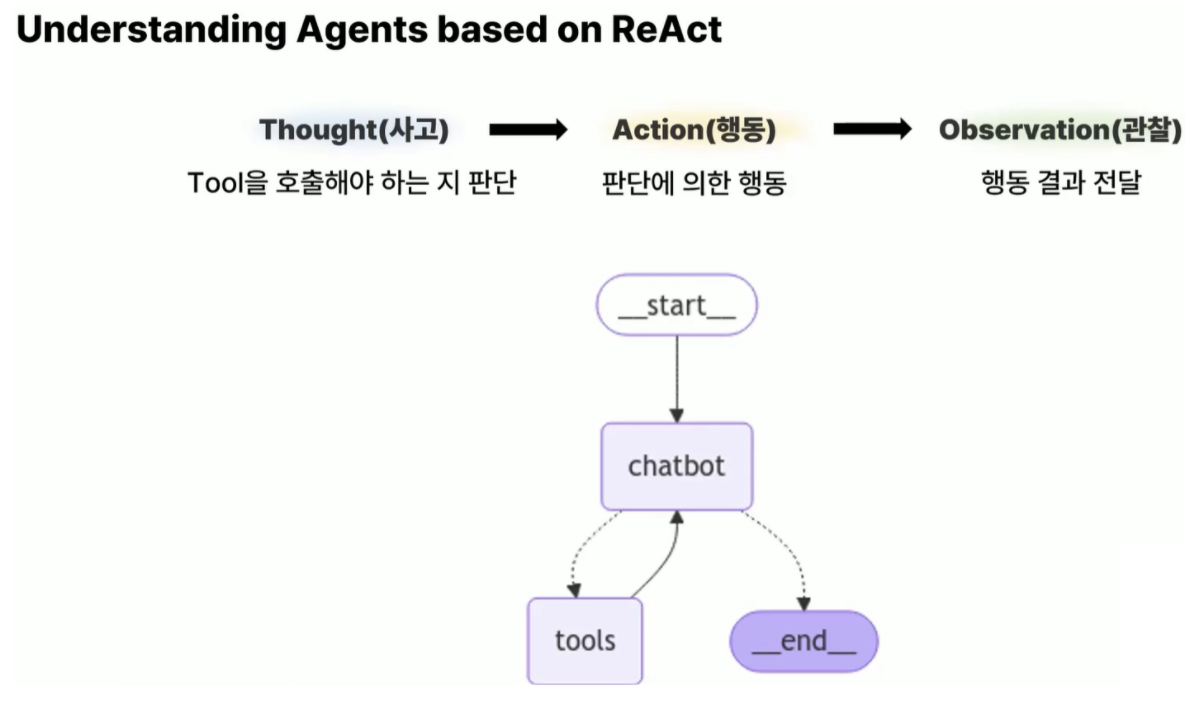

#### 위 과정을 함수로 묶어서 “미니 Agent” 만들기
- 함수로 감싸서, 질문 한 줄만 넣으면 자동으로 → 도구를 쓸지 판단 → 실행 → 최종 답변까지 해주는 “미니 에이전트”로 만들기

```python
def simple_calculator_agent(user_query: str) -> str:
    """계산기 도구 하나만 사용하는 초간단 Agent 예제"""
    # 1) 사용자 메시지
    history = [HumanMessage(content=user_query)]

    # 2) 첫 번째 LLM 호출 (도구를 쓸지 결정)
    ai_msg = llm_with_tools.invoke(history)
    history.append(ai_msg)

    # 3) 도구 호출이 없으면 그냥 답변 반환
    if not ai_msg.tool_calls:
        return ai_msg.content

    # 4) 도구 호출이 있으면 실행 후 ToolMessage 추가
    for call in ai_msg.tool_calls:
        tool_name = call["name"]
        tool_args = call["args"]

        if tool_name == "calculator":
            result = calculator.invoke(tool_args)
            history.append(
                ToolMessage(
                    content=result,
                    tool_call_id=call["id"]
                )
            )

    # 5) 최종적으로 다시 한 번 LLM 호출 → 정리된 답변
    final_ai_msg = llm_with_tools.invoke(history)
    return final_ai_msg.content
```

```python
# 테스트
print(simple_calculator_agent("3과 7을 더한 다음, 2를 곱한 값을 구해줘."))
```

# 공식 에이전트 런타임(create_agent)로 기본 에이전트 런타임 구현
- 위 실습은 수동으로 미니 에이전트 루프 구현
- 아래에서는 공식 에이전트 런타임(create_agent) 로 구현해보기

## 🤖 Tool Calling (표준 도구 호출 방식)

- **Tool Calling**은 최신 LLM(OpenAI GPT-4o, GPT-4.1, Claude 3 등)이 직접 “도구를 호출하라”는 명령을 이해하고, JSON 형태로 안정적으로 Tool을 실행하는 방식
- 즉, <font color="red">LLM이 모델 내부 기능으로 Tool을 인식하여 정확한 형식으로 호출</font> 하는 구조


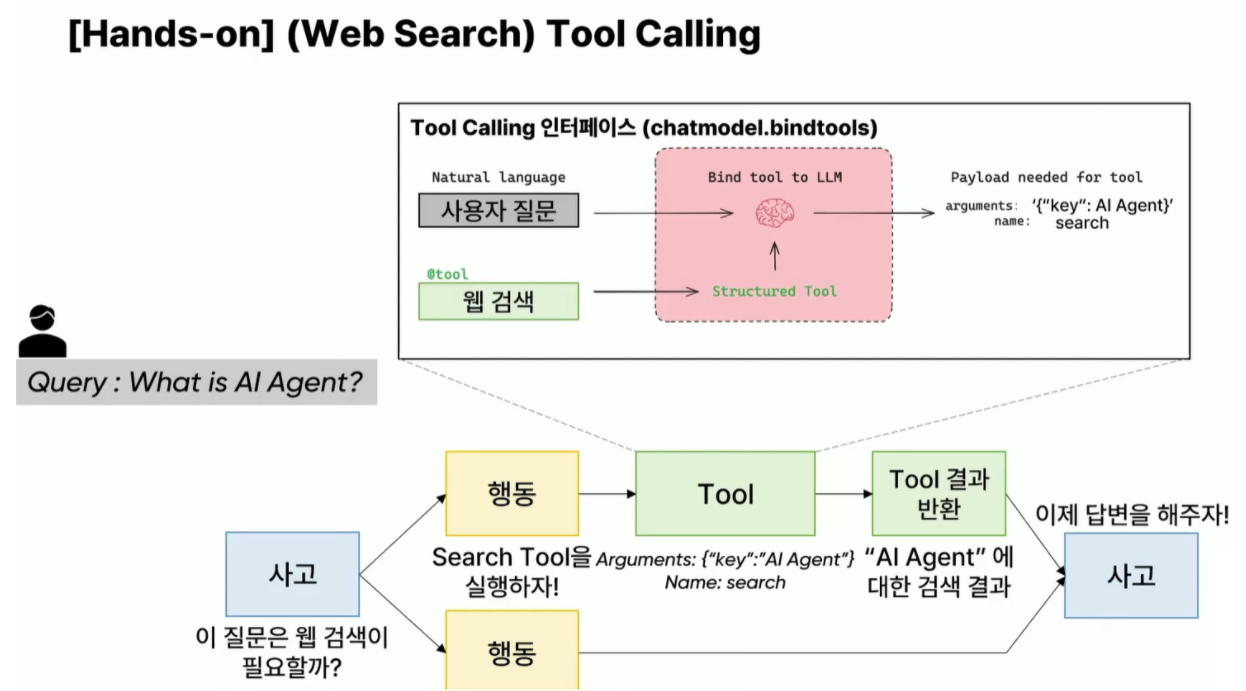

### `create_agent(...)`
- 내부적으로 <font color = "red">LangGraph 기반 그래프 실행기</font>를 만들 수 있는 도구
- <font color = "red">LangGraph</font> : 대규모 언어 모델(LLM) 기반의 복잡한 에이전트(Agent) 애플리케이션을 구축하기 위한 프레임워크

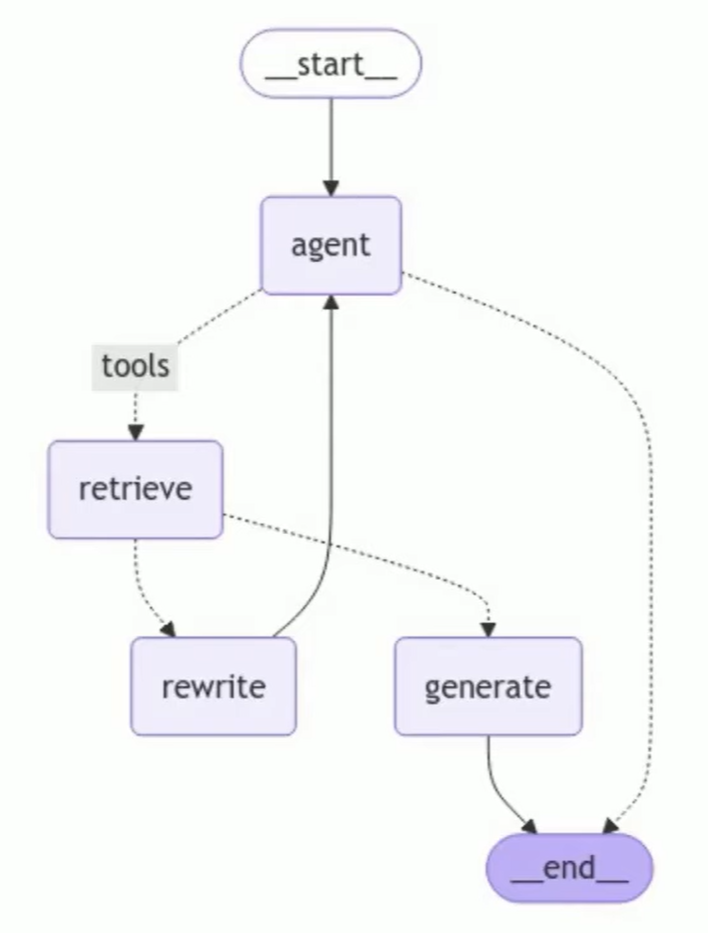

- 일반적으로 LangChain 구성 요소를 사용하지만, LangGraph를 사용하기 위해 LangChain을 사용할 필요는 없음
- 에이전트를 처음 사용하거나 더 높은 수준의 추상화를 원하는 경우, 일반적인 LLM 및 도구 호출 루프를 위한 사전 구축된 아키텍처를 제공하는 LangChain 에이전트를 사용하는 것이 좋음

> - 노드(Node): LLM 호출, 도구 실행, 미들웨어 등 “단계”
> - 엣지(Edge): 노드 사이의 연결(어떤 결과 뒤에 어떤 단계로 갈지)

> 그래프를 직접 그리진 않지만, `agent.invoke({"messages": [...]})` 한 줄을 호출하면
> 1. LangGraph가 **현재 상태(State)** 를 보고
> 2. 어느 노드(모델/도구/미들웨어)로 갈지 결정하고
> 3. ReAct 스타일로 도구를 호출/관찰/반복한 뒤
> 4. 최종 메시지를 반환


In [20]:
# LLM 모델 초기화 - llm 변수 활용

In [21]:
# 도구 정의 : 간단한 계산기 - calculator() 그대로 사용

In [22]:
# 공식 에이전트 생성기
from langchain.agents import create_agent

In [23]:
# 에이전트 그래프 생성()
basic_agent = create_agent(
    model = llm,          # 사용할 LLM : Tool Call 생성하거나, 답변을 생성하는 용도
    tools = [calculator], # 에이전트가 사용할 도구 목록 (tool 데코레이터 기반의 함수)
    system_prompt = (     # 시스템 메시지 지정 (역할, 행동 지침)
        "너는 계산을 잘하는 도우미야."
        "사용자가 수학계산을 요청하면, calculator 도구를 활용해서 정확하게 계산해줘."
        "최종 답변은 한국어로 간단하게 답변해."
    )
)

- **모델 노드 (Model Node)**  
  - LLM 호출을 담당  
  - Tool을 쓸지 말지, 어떤 Tool을 쓸지 결정  
- **툴 노드 (Tools Node)**  
  - Tool 목록을 관리하고, 실제 도구 실행을 담당  
- **루프 엣지 (Loop Edge)**  
  - `모델 → 도구 실행 → 모델 …` 을 반복  
  - 더 이상 도구가 필요 없다고 판단되면 `__end__` 엣지로 나가서 최종 답변 생성

In [24]:
# 사용자 입력값 정의
query = human_msg
query

'2와 3을 더하고, 5를 곱한 값을 계산해줘. 계산 과정은 자세히 말하지 말고, 결과만 말해'

In [25]:
# 에이전트 그래프 실행
result = basic_agent.invoke(
    {
        "messages" : [
            {"role" : "user", "content" : query}
        ]
    }
)

결과는 25입니다.

In [26]:
# 전체 메세지 로그 확인
result

{'messages': [HumanMessage(content='2와 3을 더하고, 5를 곱한 값을 계산해줘. 계산 과정은 자세히 말하지 말고, 결과만 말해', additional_kwargs={}, response_metadata={}, id='2624f0f3-7ae1-4135-88ac-510627d9079f'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_433e8c8649', 'service_tier': 'default', 'model_provider': 'openai'}, id='lc_run--019b0605-effa-7f00-90de-7452cd462519', tool_calls=[{'name': 'calculator', 'args': {'expression': '(2+3)*5'}, 'id': 'call_iVWTSEkDuX44IJk6fepxdVdJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 19, 'total_tokens': 151, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  ToolMessage(content='25', name='calculator', id='cac5a654-1169-4fc0-bf5b-d9c9dfcc6239', tool_call_id='call_iVWTSEkDuX44IJk6fepxdVdJ'),
  AIMessage(content='결과는 25입니다.', additional_kwargs={}, response_metadata={'finish_rea

```python
{
 'messages': [
  # 1) HumanMessage : 사용자가 입력한 질문
  HumanMessage(
      content='3과 7을 더한 다음, 2를 곱한 값을 구해줘. 계산 과정은 말하지 말고 결과만 말해.',
      additional_kwargs={},         # 사용되지 않은 부가 옵션
      response_metadata={},         # 응답 메타데이터 (사용자 메시지는 거의 없음)
      id='c5368...'                 # LangChain이 부여한 고유한 메시지 ID
  ),

  # 2) AIMessage (tool_call 생성됨)
  AIMessage(
      content='',                   # content가 비어있는 이유:
                                    #   → 이 메시지는 "최종 답변"이 아니라
                                    #     "도구를 호출하라"는 지시(tool_call)만 담고 있기 때문

      additional_kwargs={},         # 부가 정보 (이번 메시지 기준 없음)

      response_metadata={           # OpenAI 모델 응답 메타데이터
         'finish_reason': 'tool_calls',  
            # LLM이 “답변을 끝낸 이유”
            # tool_calls → 지금은 자연어 답변 대신 도구 호출을 선택했다는 의미

         'model_name': 'gpt-4.1-2025-04-14',
         'system_fingerprint': 'fp_433e8c8649',
         'service_tier': 'default',
         'model_provider': 'openai'
      },

      id='lc_run--4b08...',         # 메시지(LLM 응답)의 고유 ID

      tool_calls=[                  # LLM이 만든 도구 호출 요청 목록 (여기서 가장 중요!)
         {
           'name': 'calculator',       # 어떤 도구를 호출할지 (calculator)
           'args': {'expression': '(3 + 7) * 2'},  # 도구에 전달할 값
           'id': 'call_bN7D...',        # 도구 호출 고유 ID
           'type': 'tool_call'          # 이 객체가 tool_call임을 표시
         }
      ],

      usage_metadata={              # OpenAI API 토큰 사용량
         'input_tokens': 225,
         'output_tokens': 22,
         'total_tokens': 247
      }
  ),

  # 3) ToolMessage : 실제 calculator 실행 결과
  ToolMessage(
      content='20',                    # calculator 결과값
      name='calculator',               # 실행된 도구 이름
      id='bc0208bb...',                # 이 ToolMessage의 고유 ID
      tool_call_id='call_bN7D...'      # 어떤 tool_call의 응답인지 연결하기 위한 ID
  ),
  # → “도구 실행 결과(20)”를 모델에게 다시 전달하는 단계
  #   LLM은 이것을 Observation(관찰 결과)로 받아서 최종 답변을 작성

  # 4) AIMessage : LLM이 도구 결과를 보고 만든 최종 답변
  AIMessage(
      content='20입니다.',            # 최종 자연어 답변
      additional_kwargs={},
      response_metadata={
         'finish_reason': 'stop',      # stop → 자연어 답변이 끝났다는 의미
         'model_name': 'gpt-4.1-2025-04-14'
      },
      id='lc_run--f825b...',
      usage_metadata={                # 최종 호출에 사용된 토큰량
         'input_tokens': 255,
         'output_tokens': 4,
         'total_tokens': 259
      }
  )

 ]

}
```

In [27]:
# 최종 답변만 출력해보기
result["messages"][-1].content

'결과는 25입니다.'

✅ 여기까지가 앞에서 수동으로 구현했던 `LLM → tool_call → ToolMessage → LLM `흐름을 LangGraph 기반 에이전트 런타임이 대신 돌려주는 버전

# 여러 도구를 사용하는 에이전트 실습

- 이제 좀 더 “에이전트 같다” 싶은 형태로, 여러 개의 도구를 관리하는 Agent 생성해보기

    - 계산기(calculator)
    - DuckDuckGo 웹 검색 : 인터넷 프라이버시에 중점을 둔 미국의 소프트웨어 기업, 주력 제품은 덕덕고라는 이름의 웹 검색 엔진
    - Wikipedia 요약 : 위키백과

In [28]:
from langchain_community.tools import DuckDuckGoSearchRun, WikipediaQueryRun
# DuckDuckGoSearchRun : DuckDuckGo 검색 API를 호출하는 LangChain Tool 클래스
# WikipediaQueryRun : 위키백과 문서를 검색하고 요약해서 반환하는 Tool 클래스

from langchain_community.utilities import WikipediaAPIWrapper
# Wrapper : 사용할 수 있는 형태로 만들 수 있는 도구
# WikipediaQueryRun을 내부적으로 사용할 수 있도록 API 래퍼를 만들 때 쓰는 도구 ( 검색 개수, 최대 글자 수 등)

```python
⚠️ DuckDuckGo 검색 경고
DuckDuckGo는 요청이 많으면 rate limit(요청 제한)에 걸릴 수 있음
연속적인 호출은 피하고, 테스트는 몇 번만 실행하는 것을 권장
```

In [29]:
# 덕덕고 웹 검색 도구(Tool 객체)
web_search_tool = DuckDuckGoSearchRun()

In [30]:
# 위키피디아 도구(Tool 객체) - 요약 도구

# api wrapper 초기화
wiki_api = WikipediaAPIWrapper(
    top_k_results = 1,            # 검색 시 최대 1개 문서
    doc_content_chars_max = 5000, # 요약 할 때 문서 내용을 최대 5000자 사용
    lang = "ko"                   # 한국 위키피디아 선택
)

wiki_api

# Tool 객체
wiki_tool = WikipediaQueryRun(api_wrapper = wiki_api)
wiki_tool

# 동작 절차 : 위키피디아 검색 → wrapper에서 설정한 기준대로 문서 내용을 가져오기 → LLM에게 전달

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.12/dist-packages/wikipedia/__init__.py'>, top_k_results=1, lang='ko', load_all_available_meta=False, doc_content_chars_max=5000))

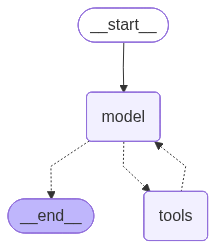

In [31]:
# 계산기 + 웹검색 + 위키겁색을 모두 쓸 수 있는 에이전트 생성
multi_tool_agent = create_agent(
    model = llm,
    tools = [calculator, web_search_tool, wiki_tool],
    system_prompt = (
        "너는 똑똑한 에이전트야."
        "수학 계산은 calculator 도구로,"
        "최신 정보나 웹 검색이 필요하면 DuckDuckGoSearchRun 도구로,"
        "백과사전의 수준의 지식은 WikipediaQueryRun 도구로 해결해."
    )
)

multi_tool_agent

In [32]:
# agent test
result = multi_tool_agent.invoke(
    {
        "messages" : [{"role" : "user", "content" : query}]
    }
)

25입니다.

- 질문을 줬을 때 에이전트가 어떤 도구를 사용하는지 눈으로 확인하는 테스트 함수로 디버깅

In [33]:
# 메세지 타입 확인 → 일반 인덱싱
print(result["messages"][1].type)

# getattr(오브젝트, 속성 이름, 기본값) → 속성 지정하는 함수
# get()랑 비슷
print(getattr(result["messages"][1], "content", ""))

ai



In [34]:
def run_and_print(agent, user_query: str):
    """
    Agent에게 질문을 보내면,
    1) 최종 답변
    2) 전체 메시지 로그 (human, ai, tool 메시지 흐름)
    3) 어떤 도구(tool)가 호출되었는지
    세 가지를 한 번에 확인할 수 있는 실습용 함수

    매개변수(parameter)
    -------------------
    agent : LangChain Agent 객체
        - create_agent(...) 또는 LangGraph 기반으로 생성한 에이전트
        - 내부적으로 LLM + Tool 실행 루프를 갖고 있음

    user_query : str
        - 사용자가 입력하는 질문
        - 예: "123 * 45 계산해줘", "LangChain이 뭐하는 라이브러리야?"
    """

    # 0) 출력 가독성을 위한 구분선
    print("\n" + "=" * 50)
    print(f"[사용자 질문] {user_query}")  # 어떤 질문을 넣었는지 출력
    print("=" * 50)

    print("\n[✅ 최종 답변]")  # ※ 스트리밍 콜백으로 LLM 응답이 바로 출력되므로, 구분용 프린트


    # 1) 에이전트 실행
    result = agent.invoke(
        {
            "messages": [
                {"role": "user", "content": user_query}
            ]
        }
    )

    # 전체 메시지 목록 꺼내기
    messages = result["messages"]

    # 2) 최종 답변 출력
    final_msg = messages[-1]
    print(getattr(final_msg, "content", ""))
    #   - obj.content가 존재하면 content 값을 가져오고, 없으면 "" 반환하여 오류 방지


    # 3) 전체 메시지 로그 출력
    print("\n[📜 전체 메시지 로그]")

    for i, m in enumerate(messages):
        print(f"\n--- 메시지 {i} ---")
        print(f"type : {m.type}")
        print(f"content : {getattr(m, 'content', '')}")
        tool_calls = getattr(m, "tool_calls", None)

        if tool_calls:
            print("tool_calls :")
            for call in tool_calls:
                # call => {'name': 도구명, 'args': 인자값, 'id': 호출ID}
                print(f"  - name : {call['name']}, args : {call['args']}")


    # 4) 이번 질의에서 실제로 사용된 도구 요약
    used_tools = []

    for m in messages:
        tool_calls = getattr(m, "tool_calls", None)
        if tool_calls:
            for call in tool_calls:
                used_tools.append(call["name"])   # 도구 이름만 저장

    print("\n[🔍 이번 질의에서 사용된 도구 요약]")
    if used_tools:
        # set()으로 중복 제거 → ", ".join()으로 예쁘게 출력
        print("사용된 도구 :", ", ".join(set(used_tools)))
    else:
        print("사용된 도구 없음 (LLM 단독 응답)")

In [35]:
# 1. 수학 중심 질문
run_and_print(multi_tool_agent, "123*45를 계산해줘. 계산 과정은 말하지 말고 결과만 말해")


[사용자 질문] 123*45를 계산해줘. 계산 과정은 말하지 말고 결과만 말해

[✅ 최종 답변]
55355535

[📜 전체 메시지 로그]

--- 메시지 0 ---
type : human
content : 123*45를 계산해줘. 계산 과정은 말하지 말고 결과만 말해

--- 메시지 1 ---
type : ai
content : 
tool_calls :
  - name : calculator, args : {'expression': '123*45'}

--- 메시지 2 ---
type : tool
content : 5535

--- 메시지 3 ---
type : ai
content : 5535

[🔍 이번 질의에서 사용된 도구 요약]
사용된 도구 : calculator


In [36]:
# 2. 일반적인 질문 - Tool 사용 X
run_and_print(multi_tool_agent, "LangChain이 뭐하는 라이브러리인지 간단하게 설명해줘")


[사용자 질문] LangChain이 뭐하는 라이브러리인지 간단하게 설명해줘

[✅ 최종 답변]
LangChain은 자연어 처리(NLP)와 인공지능(AI) 언어 모델(예: GPT-4 등)을 활용한 애플리케이션을 쉽게 만들 수 있도록 도와주는 파이썬 기반 오픈소스 라이브러리입니다.  
주요 특징은 다음과 같습니다:

- 다양한 언어 모델과 쉽게 연동할 수 있음
- 프롬프트 관리, 체인(여러 작업의 연결), 에이전트(동적으로 작업 수행) 등 고급 기능 제공
- 외부 데이터(문서, 데이터베이스 등)와 연동하여 언어 모델이 더 똑똑하게 동작하도록 지원

즉, LangChain은 챗봇, Q&A 시스템, 문서 요약 등 언어 모델을 활용한 다양한 AI 서비스를 빠르고 쉽게 개발할 수 있게 해주는 도구입니다.LangChain은 자연어 처리(NLP)와 인공지능(AI) 언어 모델(예: GPT-4 등)을 활용한 애플리케이션을 쉽게 만들 수 있도록 도와주는 파이썬 기반 오픈소스 라이브러리입니다.  
주요 특징은 다음과 같습니다:

- 다양한 언어 모델과 쉽게 연동할 수 있음
- 프롬프트 관리, 체인(여러 작업의 연결), 에이전트(동적으로 작업 수행) 등 고급 기능 제공
- 외부 데이터(문서, 데이터베이스 등)와 연동하여 언어 모델이 더 똑똑하게 동작하도록 지원

즉, LangChain은 챗봇, Q&A 시스템, 문서 요약 등 언어 모델을 활용한 다양한 AI 서비스를 빠르고 쉽게 개발할 수 있게 해주는 도구입니다.

[📜 전체 메시지 로그]

--- 메시지 0 ---
type : human
content : LangChain이 뭐하는 라이브러리인지 간단하게 설명해줘

--- 메시지 1 ---
type : ai
content : LangChain은 자연어 처리(NLP)와 인공지능(AI) 언어 모델(예: GPT-4 등)을 활용한 애플리케이션을 쉽게 만들 수 있도록 도와주는 파이썬 기반 오픈소스 라이브러리입니다.  
주요 특징은 다음과 같습니다:

- 다양한 언어 모델과 쉽게 연동할 수 있

In [37]:
# 3. 위키/웹 검색이 필요한 질문
run_and_print(multi_tool_agent, "LangChain이 뭐하는 라이브러리인지 wiki에서 찾아서 설명해줘")


[사용자 질문] LangChain이 뭐하는 라이브러리인지 wiki에서 찾아서 설명해줘

[✅ 최종 답변]
LangChain(랭체인)은 대형 언어 모델(LLM)을 활용한 애플리케이션 개발을 쉽게 만들어주는 프레임워크입니다. 주로 문서 분석 및 요약, 챗봇, 코드 분석 등 다양한 언어 모델 기반의 기능을 구현할 때 사용됩니다. 즉, 언어 모델을 실제 서비스나 프로그램에 통합할 때 유용하게 쓰이는 라이브러리입니다.LangChain(랭체인)은 대형 언어 모델(LLM)을 활용한 애플리케이션 개발을 쉽게 만들어주는 프레임워크입니다. 주로 문서 분석 및 요약, 챗봇, 코드 분석 등 다양한 언어 모델 기반의 기능을 구현할 때 사용됩니다. 즉, 언어 모델을 실제 서비스나 프로그램에 통합할 때 유용하게 쓰이는 라이브러리입니다.

[📜 전체 메시지 로그]

--- 메시지 0 ---
type : human
content : LangChain이 뭐하는 라이브러리인지 wiki에서 찾아서 설명해줘

--- 메시지 1 ---
type : ai
content : 
tool_calls :
  - name : wikipedia, args : {'query': 'LangChain'}

--- 메시지 2 ---
type : tool
content : Page: 랭체인
Summary: 랭체인(LangChain)은 LLM(대형 언어 모델)을 사용하여 애플리케이션 생성을 단순화하도록 설계된 프레임워크이다. 언어 모델 통합 프레임워크로서 랭체인의 사용 사례는 문서 분석 및 요약, 챗봇, 코드 분석을 포함하여 일반적인 언어 모델의 사용 사례와 크게 겹친다.

--- 메시지 3 ---
type : ai
content : LangChain(랭체인)은 대형 언어 모델(LLM)을 활용한 애플리케이션 개발을 쉽게 만들어주는 프레임워크입니다. 주로 문서 분석 및 요약, 챗봇, 코드 분석 등 다양한 언어 모델 기반의 기능을 구현할 때 사용됩니다. 즉, 언어 모델을 실제 서비스나 프로그램에 통합할 때 유용하게 쓰이는 

# 그래프 커스터마이징(LangGraph로 검색 Agent 챗봇 만들기)
- 앞에서는 `llm.bind_tools(...)` 로 도구 바인딩, `create_agent(...)` 로 공식 에이전트 런타임 사용
- 이번에는 한 단계 더 나가서, LangGraph로 “에이전트 그래프”를 직접 구성해서 검색 챗봇을 만들어보기

- LangGraph의 강점은 **사용자가 직접 그래프를 정의**하여 에이전트의 흐름을 세밀하게 제어할 수 있다는 점
그러나 이를 위해서는 아래와 같은 추가 개념 이해 필요

> - **상태(State) 정의**: `TypedDict` 나 dataclass를 사용해 상태의 스키마를 정의, 그래프에서 전달되는 데이터 구조를 명시
> - **노드(Node) 작성**: 각 노드는 상태를 입력받아 업데이트된 상태를 반환하는 함수, LLM 호출/도구 실행/조건 검사 등을 노드로 정의합니다.
> - **간선(Edges) 설정**: 노드 사이의 연결을 정의하며, 조건에 따라 다른 노드로 분기할 수 있음. `add_conditional_edges()`를 사용해 조건부 분기를 만들 수 있음
> - **그래프 컴파일**: `StateGraph`에 노드와 간선을 추가한 후 `.compile()` 메서드로 그래프를 최종 생성

- 그래프를 직접 구성하면 도구 사용 순서, 반복 조건, 병렬 실행 등을 세밀하게 제어 가능

### Tavily 검색 Tool & LLM 준비
- https://app.tavily.com/home 에서 API Key 발급

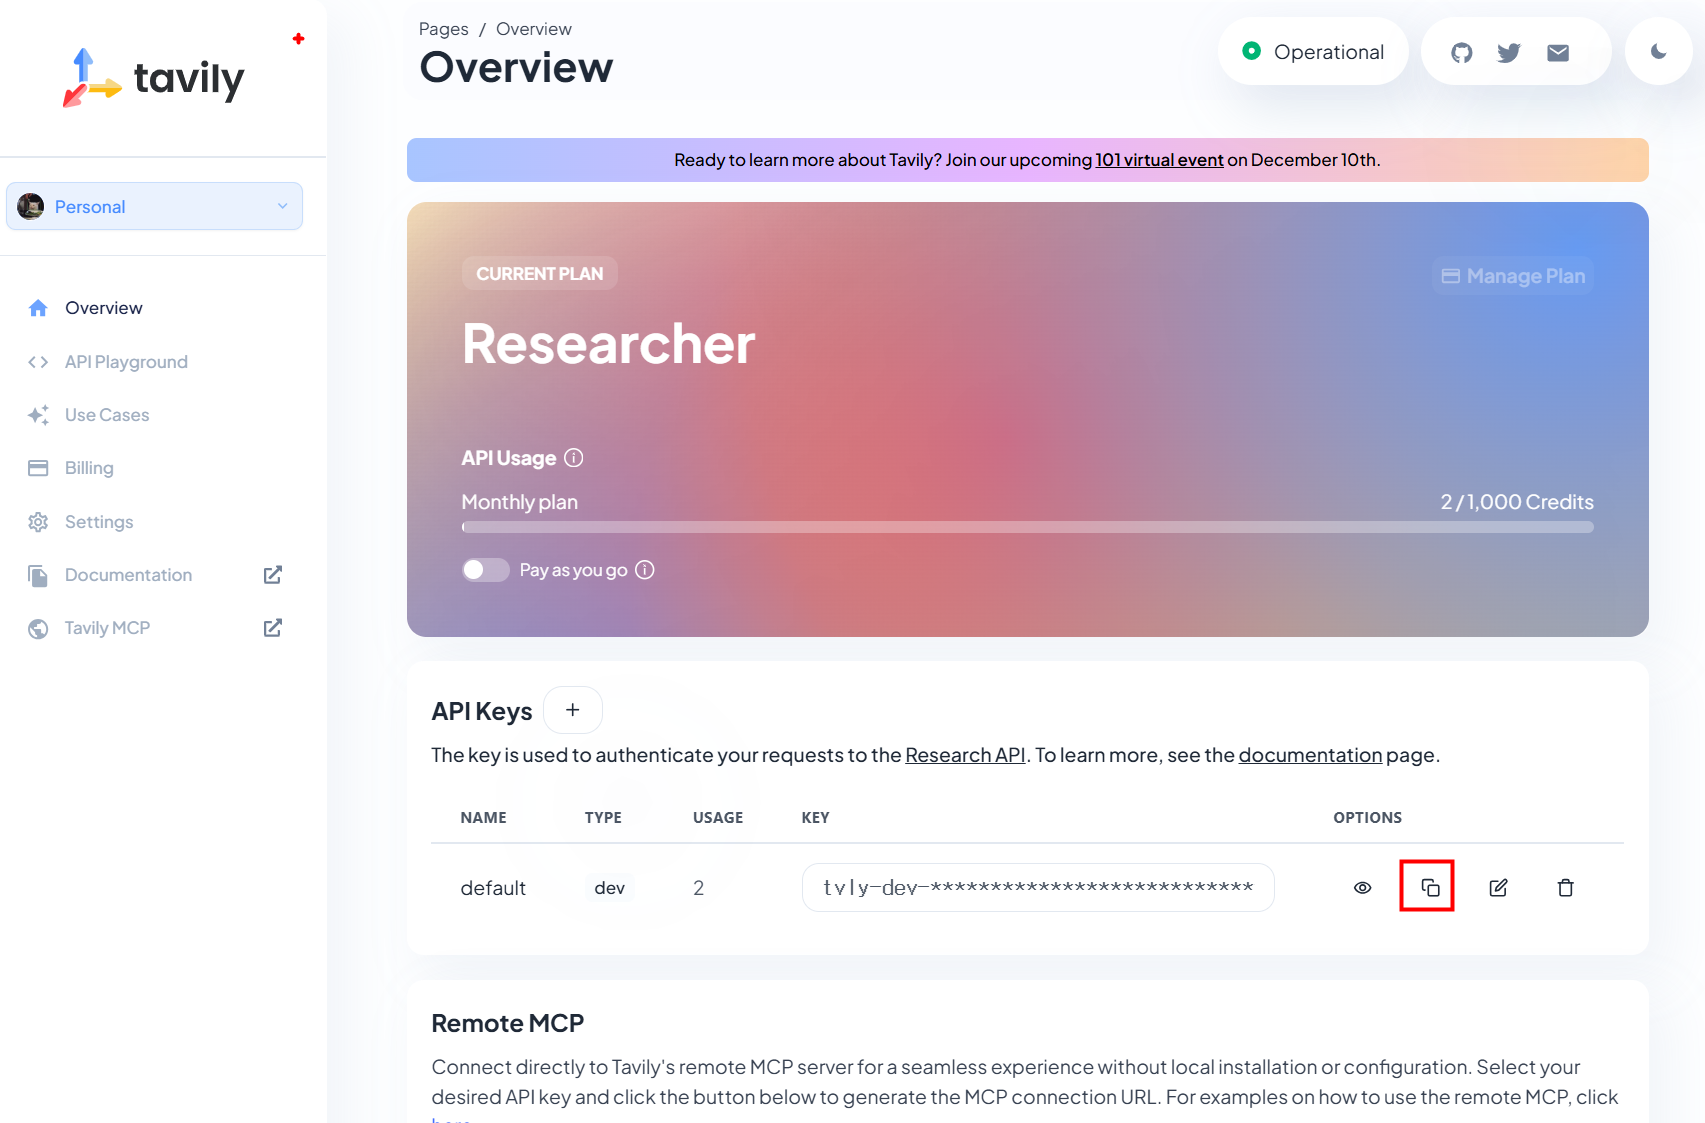

In [ ]:
# Tavily API 키 등록
os.environ["TAVILY_API_KEY"] = ""

### Tavily Search Tool 준비, LLM + Tool Binding

In [39]:
from langchain_tavily import TavilySearch # 검색 툴 만드는 도구

In [40]:
# 검색 툴 초기화
tavily_tool = TavilySearch(max_results = 3)

In [41]:
# 테스트
tavily_tool.invoke("AI Agent가 뭐야?")

{'query': 'AI Agent가 뭐야?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.naver.com/dxtrend/223732957973',
   'title': 'AI에이전트(AI Agent)란 무엇인가? : 네이버 블로그',
   'content': 'AI 에이전트는 특정 목표를 달성하기 위해 자율적으로 행동하고 결정을 내리는 지능형 시스템이다. 단순한 규칙 기반 로직을 넘어, 복잡한 계획, 추론,',
   'score': 0.8961153,
   'raw_content': None},
  {'url': 'https://www.samsungsds.com/kr/insights/what-are-ai-agents.html',
   'title': 'AI 에이전트 AI Agents 란 무엇인가? | 인사이트리포트 | 삼성SDS',
   'content': 'AI 에이전트(AI Agents)란 유저가 정의한 목표을 달성하기 위해 AI 모델을 활용하여 환경과 상호작용하는 시스템으로, 추론(reasoning), 계획(planning),',
   'score': 0.885404,
   'raw_content': None},
  {'url': 'https://namu.wiki/w/%EC%A7%80%EB%8A%A5%ED%98%95%20%EC%97%90%EC%9D%B4%EC%A0%84%ED%8A%B8',
   'title': '지능형 에이전트 - 나무위키',
   'content': '지능형 에이전트(知能型 agent) 또는 인공지능 에이전트(人工知能 agent)는 생성형 인공지능 기술의 한 분야로, 사람이 설정한 목표를 달성하기 위해 외부 개입 없이',
   'score': 0.8775715,
   'raw_content': None}],
 'response_time': 0.0,
 'request_id': '4641f42b-3cf1-43

In [42]:
# 바인딩 - 도구를 사용할 수 있는 LLM 생성
llm_with_tavily = llm.bind_tools([tavily_tool])
llm_with_tavily

RunnableBinding(bound=ChatOpenAI(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7d739e60c5c0>], profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7d739c722330>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7d739bebd280>, root_client=<openai.OpenAI object at 0x7d739c8627e0>, root_async_client=<openai.AsyncOpenAI object at 0x7d739c16b7a0>, model_name='gpt-4.1', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True, streaming=True, max

## LangGraph 기반 검색 Agent Graph 구성

In [43]:
# 타입힌트 명시
from typing import Annotated, List
from typing_extensions import TypedDict
import json

# 랭그래프 누적 함수
from langgraph.graph.message import add_messages

from langchain_core.messages import BaseMessage # HumanMessage, AIMessage, ToolMessage 의 부모 클래스
from langchain_core.messages import ToolMessage # 도구 실행 결과를 LLM에게 전달할 때 사용하는 메시지 타입

from langgraph.graph import StateGraph, START, END
# StateGraph : 그래프 구조(노드+엣지)를 정의하는 빌더 클래스
# START, END : 그래프의 시작/종료 지점을 나타내는 특수 노드 이름

#### 1) State 정의
- LangGraph에서는 모든 정보를 `state` 라는 하나의 "딕셔너리"에 담아서 주고받음
- 클래스로 정의 (`딕셔너리 구조를 설명하기 위한 껍데기`)

In [44]:
# 그래프에서 전달·공유할 "상태(State)의 형태"를 타입으로 정의
class State(TypedDict):
    messages : Annotated [List[ BaseMessage ], add_messages ]

#### 2) 그래프 빌더 생성

In [45]:
# "State"를 가지고 도는 그래프를 하나 만들겠다라고 선언
graph_builder = StateGraph(State)

In [46]:
graph_builder
# 이후에 노드를 쌓았거나, 엣지를 연결하는 형태로 그래프를 완성시킬 수 있음

#### 3) chatbot 노드 (LLM 호출 담당)


In [47]:
# 도구를 쓸 수 있는 LLM 초기화 - llm_with_tools 변수 활용

In [48]:
# 상태(메세지 세트)를 전달받아서 새오운 메세지를 만들어서 반환하는 llm 함수
def chatbot(state : State) :
  ai_msg = llm_with_tavily(state["messages"])
  return {"messages" : [ai_msg]}

In [49]:
# 챗봇 노드를 그래프에 등록
graph_builder.add_node("chatbot", chatbot)

#### 4) Tool Node (도구 실행 담당)
- 여기서는 실제 Tavily 검색을 실행하는 단계

In [50]:
class BasicToolNode:
    """
    해당 클래스는 "도구를 실제 실행하는 기계" 역할을 수행

    붕어빵 비유로 설명하면:
    - class BasicToolNode      → '붕어빵 틀' (설계도)
    - BasicToolNode(...) 생성 → '붕어빵 틀로 붕어빵 한 개(self)' 만들기
    - __init__                → 붕어빵 속(팥/슈크림)을 채워넣는 단계
    - __call__                → 틀(self)에게 "붕어빵 하나 만들어줘"라고 요청하는 동작
    """

    # 1) __init__ : 붕어빵 속재료(도구 목록)를 채워 넣는 단계
    def __init__(self, tools: list):
        """
        __init__ : "객체를 만들 때 자동으로 실행되는 함수" (생성자 메서드)

        붕어빵 비유:
        - '붕어빵 틀'을 만들어서 손에 들었을 때, 그 틀 안에는 이미 팥/슈크림 같은 속재료가 채워져 있다.
          그 속재료를 넣어주는 단계가 __init__.

        self : '지금 만들어지고 있는 그 붕어빵 틀(객체)'을 가리킴
        - self.tools_by_name 하면, 그 틀만의 속재료(도구 목록)를 꺼내 쓸 수 있음
        """

        # 도구 목록을 {도구이름: 도구객체} 형태의 딕셔너리로 저장
        # → 이게 바로 붕어빵 ‘속재료 통’
        self.tools_by_name = { tool.name: tool for tool in tools }

    # 2) __call__ : 이 객체를 ‘함수처럼’ 호출할 수 있게 만들어 주는 기능
    def __call__(self, inputs: dict):
        """
        __call__ :  "객체를 함수처럼 사용할 수 있게 해주는 함수" (파이썬의 특별한 메소드로, 클래스의 인스턴스가 함수처럼 호출될 수 있도록 만드는 기능)

        예:
            tool_node = BasicToolNode([...])
            tool_node(inputs)  ← 이렇게 괄호로 호출하면 __call__이 실행되는 것
        """

        # inputs 안의 messages 목록을 꺼내고 마지막 메시지를 가져옴
        # LLM이 "이 도구 좀 써줘!"라고 요청한 tool_call 정보가 여기에 들어 있음
        messages = inputs.get("messages", [])
        last_msg = messages[-1]

        outputs = []

        # 마지막 AIMessage에 들어 있는 tool_call 요청을 하나씩 실행
        for tool_call in last_msg.tool_calls:

            tool_name = tool_call["name"]   # 예: "tavily_search"
            tool_args = tool_call["args"]   # 예: {"query": "AI Agent가 뭐야?"}

            # 실제 도구 실행
            # self.tools_by_name는 __init__에서 저장해둔 "도구 속재료 통"
            result = self.tools_by_name[tool_name].invoke(tool_args)

            # 도구 실행 결과(result)를 ToolMessage로 감싸서 LLM에게 전달할 준비
            outputs.append(
                ToolMessage(
                    # json.dumps() : 파이썬 객체(dict, list 등)를 "JSON 문자열"로 변환하는 함수
                    # LLM에게 전달할 content는 문자열이어야 하므로 JSON 문자열로 바꿔주는 것이 필수
                    content = json.dumps(result, ensure_ascii = False),
                    #   1) result :  Tavily 검색 결과 (dict 타입) → 문자열 변환 필요
                    #   2) ensure_ascii = False
                    #       - 기본값(True)에서는 모든 글자를 ASCII로 변환함 → 한글이 깨짐
                    #         예: "안녕하세요" → "\uC548\uB155..."
                    #       - False로 설정하면 한글/유니코드를 그대로 유지
                    #         예: "안녕하세요" 그대로 출력
                    #   즉, JSON 변환 시 한글 깨짐 없이 LLM에게 전달하기 위해 반드시 False로 설정!

                    #   - 도구 실행 결과를 JSON 문자열 형태로 저장
                    #   - LangGraph가 이 값을 LLM에게 다시 전달해 다음 단계 추론에 사용

                    name = tool_name,
                    #   - 어떤 도구가 실행되었는지 알리는 필드
                    #   - 예: "tavily_search"

                    tool_call_id = tool_call["id"],
                    #   - LLM이 요청했던 tool_call과 "이 결과가 이어지는 것"을 연결
                    #   - LLM이 여러 개의 도구를 호출했을 때 어떤 결과가 어떤 호출의 응답인지 구분하기 위해 필요
                )
            )

        # LangGraph에서는 {"messages": [...]} 형태로 반환하면, 메시지를 자동으로 이어붙여서 다음 노드(chatbot)로 전달
        return {"messages": outputs}

In [51]:
# ToolNode 객체 생성
tool_node = BasicToolNode(tools = [tavily_tool])

# ToolNode를 그래프에 추가
graph_builder.add_node("tools", tool_node)

#### 5) 조건부 엣지 (tool_calls가 있으면 tools로, 없으면 끝으로)

In [52]:
# 도구 호출 했을 때 메세지 확인
print(hasattr(result["messages"][1], "tool_calls"))
print(result["messages"][1].tool_calls)
print((hasattr(result["messages"][1], "tool_calls")) and (result["messages"][1].tool_calls))

# ai가 content를 만들어낸 당시에 메세지 확인
print(hasattr(result["messages"][-1], "tool_calls"))
print(result["messages"][-1].tool_calls)
print((hasattr(result["messages"][-1], "tool_calls")) and (result["messages"][-1].tool_calls))

True
[{'name': 'calculator', 'args': {'expression': '(2+3)*5'}, 'id': 'call_GLpQVbXZS82hncT5LDY3b0uW', 'type': 'tool_call'}]
[{'name': 'calculator', 'args': {'expression': '(2+3)*5'}, 'id': 'call_GLpQVbXZS82hncT5LDY3b0uW', 'type': 'tool_call'}]
True
[]
[]


In [53]:
def route_tools(state: State):
    """
    chatbot 노드 실행 후,
    LLM이 만든 AIMessage에 '도구를 호출하라(tool_call)'라는 정보가 있으면 → tools 노드로 이동
    도구 호출이 필요 없으면 → END 로 보내서 그래프 종료

    즉, "다음에 어디로 갈지(어떤 노드를 실행할지) 결정하는 교차로" 역할
    """
    messages = state.get("messages", [])
    last_msg = messages[-1]

    # tool_calling이 진행 되었는지 확인
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls :
        return "tools" # tool_calls 리스트가 비어있지 않으면(True로 작동)
                       # tools 문자열 반환 (툴 노드를 실행하러 이동시키겠다)

    return END

In [54]:
# 조건부 엣지 추가하는 함수 적용
graph_builder.add_conditional_edges("chatbot", route_tools, {"tools" : "tools", END : END})

In [55]:
# 일반 엣지 추가하는 함수 적용
graph_builder.add_edge("tools", "chatbot") # tools를 실행시키면, 다시 chatbot에게 전달하도록 엣지 연결

graph_builder.add_edge(START, "chatbot") # 그래프 시작 지점, chatbot 노드 연결

#### 6) 그래프 컴파일

In [56]:
graph = graph_builder.compile()

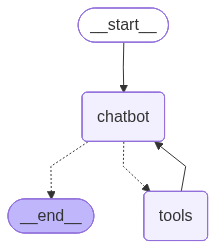

In [57]:
graph

#### 검색 Agent 실행

In [58]:
# Agent 테스트
result = graph.invoke(
    {
        "messages" : [
            {
                "role" : "user",
                "content" : "AI Agent가 뭔지 검색해서 설명해줘"
            }
        ]
    }
)

TypeError: 'RunnableBinding' object is not callable

In [ ]:
result["messages"][1]

## Agent 챗봇 만들기

In [ ]:
# LangGraph의 stream() 기능을 사용하여, 에이전트가 "생각 → 도구 요청 → 도구 실행 → 다시 생각"
# 하는 전체 내부 과정을 프레임(한 장면) 단위로 실시간 출력해주는 함수

def stream_graph_updates(user_input: str):
    print(f"\n[User] {user_input}")

    graph_stream = graph.stream(
        {"messages" : [{"role": "user", "content": user_input}]},
        stream_mode="values"
    )

    for state in graph_stream :
        messages = state["messages"]
        last_msg = messages[-1]

        # 1) ToolMessage 단계
        if last_msg.type == "tool":
            print(f"[Tool Executed] {last_msg.name}")
            continue

        # 2) LLM이 도구를 사용하겠다고 요청하는 단계
        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            for call in last_msg.tool_calls:
                print(
                    f"[Agent decided to use Tool] "
                    f"{call['name']} with args {call['args']}"
                )
            continue

In [ ]:
# 챗봇 구현
while True :
  user_input = input("\n 사용자 입력 (q, quit, exit 종료) >> ")
  if user_input.lower() in ["q", "quit", "exit"] :
    print("종료합니다")
    break
  stream_graph_updates(user_input)

# AI Agent가 뭐야? - Tool 사용 X

# Tool 호출
# AI Agent가 뭔지 웹 검색 기능으로 설명해줘봐
# AI Agent에 대해서도 검색해서 설명해주고, LangChain